#TFM - Análisis de la evolución de noticias falsas en Twitter

##Fase 01 - Scraping.

En esta fase utilizaremos el API de Twitter para encontrar una noticia falsa y poder interactuar con ella.

##Fuentes
###Analisis Twitter
- [Hands-On Guide to Download, Analyze and Visualize Twitter Data](https://analyticsindiamag.com/hands-on-guide-to-download-analyze-and-visualize-twitter-data/)

###Working with CSV
- [Python Write CSV File](https://www.pythontutorial.net/python-basics/python-write-csv-file/)

###tweepy 
- [How to Scrape More Information From Tweets on Twitter](https://towardsdatascience.com/how-to-scrape-more-information-from-tweets-on-twitter-44fd540b8a1f)
- [Getting full tweet text from "user_timeline" with tweepy](https://stackoverflow.com/questions/42705314/getting-full-tweet-text-from-user-timeline-with-tweepy)
- [Lesson 2. Automate Getting Twitter Data in Python Using Tweepy and API Access](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/)

Algoritmo pasado por Alejandro Martin Garcia para el TFM:
Para hacer comparaciones semánticas de tweets mediante embeddings, te recomiendo Sentence-BERT*.

Lo ideal es que tengas un conjunto de tweets descargado que sabes que trata el tema sobre el que vas a hacer un análisis de su evolución. Necesitas tenerlos ya para poder calcular los embeddings de todos ellos. Podríamos plantear algo dinámico, pero no creo que tengamos tiempo suficiente.

Por ello te recomiendo el siguiente plan de trabajo:

- Céntrate en 1 noticia falsa para luego exportar a 3 o 4. 
-- Para cada una de ellas, tendrías que descargarte un conjunto de tweets que sea lo suficientemente grande para hacer algo interesante. Para ello, te recomiendo que te definas una cadena de búsqueda con keywords **para cada una de esas noticias falsas** y la lances al API de twitter. Con ello te descargarás un conjunto de N tweets que contengan las keywords que has utilizado en la búsqueda. Necesitas una búsqueda lo suficientemente amplia para no céntrarte únicamente en los que tengan la noticia falsa escrita siempre de la misma forma. Te conviene tener tweets que hablen de otras cosas.

- Genera los embeddings de todos esos tweets.

- Selecciona un tweet concreto T0 a mano que nos sirva de punto de partida: debe contener el bulo de la forma más clara y tener la fecha más antigua posible.

- Diseña una estrategia para calcular distancias y establecer las distancias entre pares de tweets. Esto te generará una matrix o un grafo: tendrás una distancia entre cada par de tweets (nodos).

Vamos a utilizar una noticia falsa sobre un teórico tsuname causado por el volcán Cumbre Vieja:

https://twitter.com/i/web/status/1437906277859045376


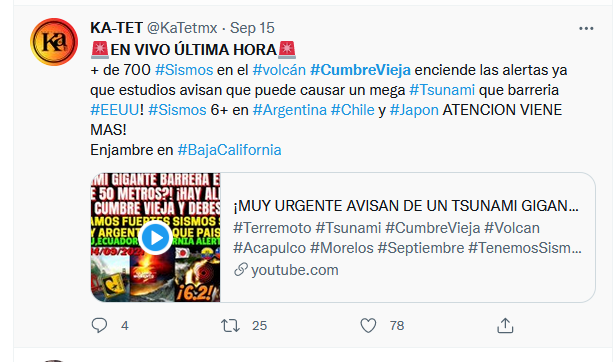

In [ ]:
#################################################
# Importing Libraries
#################################################
import tweepy
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import json
from collections import Counter

# Needed to create/load csv file with twits
import csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
######################################################
# Mount google drive and use folder of data
######################################################
from google.colab import drive
drive.mount('/content/drive/')
BASE_FOLDER = '/content/drive/My Drive/Colab Notebooks/09_TFM/c_vieja_data/'


Mounted at /content/drive/


In [ ]:
#################################################################
#Authorization and Search tweets
#Getting authorization
#################################################################
consumer_key = 'BVjiq6zsiVyMZddCAEQWecifR'
consumer_key_secret = 'P2TJjdxOUg73wP8oDL6rR3UL8d1NXpvBmVJyS3v3Ss4QMvixNW'
access_token = '1438422348433133574-dwxfha6i7OytpH0n5PHkoAY4L8fsPI'
access_token_secret = 'st0CWyXbeOUwKDszQGwhtH6q5qOU4W0l6tWTNC5maFuJp'
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
#################################################################
# Method which write tweets on files
#
# Creating Dataframe of Tweets
# Cleaning searched tweets and converting into Dataframe
#################################################################
def tweets2files(searched_tweets, fileNamePattern):

    json_file_fullname = BASE_FOLDER+'20210922_twits_'+fileNamePattern+'.json'
    csv_file_fullname = BASE_FOLDER+'20210922_twits_'+fileNamePattern+'.csv'
    csv_text_file_fullname = BASE_FOLDER+'20210922_only_text_twits_'+fileNamePattern+'.csv'

    my_list_of_dicts = []
    for each_json_tweet in searched_tweets:
        my_list_of_dicts.append(each_json_tweet._json)

    #   
    with open(json_file_fullname, 'w') as file:
            file.write(json.dumps(my_list_of_dicts, indent=4))

    #
    my_demo_list = []
    with open(json_file_fullname, encoding='utf-8') as json_file:  
        all_data = json.load(json_file)
        for each_dictionary in all_data:
            tweet_id = each_dictionary['id']
            #text = each_dictionary['text']
            text = each_dictionary['full_text']
            favorite_count = each_dictionary['favorite_count']
            retweet_count = each_dictionary['retweet_count']
            created_at = each_dictionary['created_at']

            #
            my_demo_list.append({'tweet_id': str(tweet_id),
                                'text': str(text),
                                'favorite_count': int(favorite_count),
                                'retweet_count': int(retweet_count),
                                'created_at': created_at,
                                })
            
            #
            tweet_dataset = pd.DataFrame(my_demo_list, columns = 
                                      ['tweet_id', 'text', 
                                      'favorite_count', 'retweet_count', 
                                      'created_at'])
            
            #
            only_tweet_dataset = pd.DataFrame(my_demo_list, columns = ['text'])
        #for
    #with

    #Writing tweet dataset to csv file for future reference
    tweet_dataset.to_csv(csv_file_fullname, index=False)

    #Writing only the text to csv file for future reference
    only_tweet_dataset.to_csv(csv_text_file_fullname, index=False)
#def

In [ ]:
#################################################################
# Via api we try to get the fake news tweet detected for work
#################################################################
# query by user name
username_4_search = 'KaTetmx'#Usuario que publico noticia falsa sobre el tsunami de Cumbre Vieja
max_tweets = 1000

# with parameter tweet_mode="extended", we try to get full tweet text
searched_tweets = tweepy.Cursor(api.user_timeline,id=username_4_search, tweet_mode="extended").items(max_tweets)

#
tweets2files(searched_tweets, username_4_search)

In [ ]:
##type(searched_tweets)
##print(searched_tweets[0])

Tras el escaneo (scraping) para encontrar la noticia en Twitter, damos con ella:


```
96,1437906277859045376,"🚨EN VIVO ÚLTIMA HORA🚨
+ de 700 #Sismos en el #volcán #CumbreVieja enciende las alertas ya que estudios avisan que puede causar un mega #Tsunami que barreria #EEUU! #Sismos 6+ en #Argentina #Chile y #Japon ATENCION VIENE MAS!
Enjambre en #BajaCalifornia
https://t.co/2MoadwVH7I",78,23,Tue Sep 14 22:29:06 +0000 2021
```



Con la noticia falsa, me descargo los posibles twits relacionados

In [ ]:
#################################################################
# Via api we try to get related tweets about fake news
#################################################################
#Defining Search keyword and number of tweets and searching tweets
max_tweets = 1000

# Get tweets: full text, in spanish, 
query1 = 'megatsunami'
searched_tweets = [status for status in tweepy.Cursor(api.search, q=query1, tweet_mode="extended", lang="es").items(max_tweets)]
tweets2files(searched_tweets, query1)

#
query2 = 'Mega-Tsunami'
searched_tweets = [status for status in tweepy.Cursor(api.search, q=query2, tweet_mode="extended", lang="es").items(max_tweets)]
tweets2files(searched_tweets, query2)


In [ ]:

#################################################################
# Via api we try to get related tweets about the target of the fake news
#################################################################
max_tweets = 3000
query3 = 'Cumbre AND Vieja'
searched_tweets = [status for status in tweepy.Cursor(api.search, q=query3, tweet_mode="extended", lang="es").items(2500)]
tweets2files(searched_tweets, "CumbreVieja")